## Electrochemical Impedance Spectroscopy

Electrochemical Impedance Spectroscopy, or EIS for short, is an analytical technique for probing the inner workings of an electrochemical system like a battery or fuel cell. In principle, it could also be used for any unknown electrical circuit. It works by introducing unit impulses to the circuit at a range of frequencies and measuring the impedance.

Gamry, a manufacturer of potentiostats that can be used to perform EIS measurements, [has a good primer on the subject](https://www.gamry.com/application-notes/EIS/basics-of-electrochemical-impedance-spectroscopy/).

I'm also familiar with the math behind EIS by a background in [Control Theory](https://en.wikipedia.org/wiki/Control_theory) and didn't learn it as an electrochemist might. So the wording may make more sense to an electrical engineer or chemical engineer than it might an electrochemist (who is more likely to use it).

The short explaination is an equivalent circuit is set up with several individual circuit elements and the liberal application of [Ohm's Law](https://en.wikipedia.org/wiki/Ohm%27s_law) and worked up using either Laplace Transformations (as I do here) or Fourier Transformations (a special case of Laplace Transformations and how most EIS literature does it). The impedance response is a complex number.

The advantage to doing it in the frequency domain is all the math is algebra and all the complicated dynamics of the differential equations are removed by the transform. Working with the data as Laplace Transforms also allows (usually) convenient conversion between frequency and time domains.

A [Gamry Interface 1010E Potentiostat](https://www.gamry.com/potentiostats/interface-1010e-potentiostat/) (the machine I'm most familiar with) has a range of 2 MHz to 10 μHz. Low frequencies take a long time to run in practice, but may be necessary to probe things like diffusion. 

Here I'm going to: 
* Set up Python classes for common circuit elements
* Set up a Python class for an Equivalent Circuit made of of those individual elements
* Plot Nyquist and Bode diagrams for example data
* Return those data as a pandas dataframe

First we need to import a couple libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Next let's define the frequency range from 10 μHz to 0.1 MHz:

In [2]:
myFrequencies = np.logspace(5,-5,num=101)
myFrequencies

array([1.00000000e+05, 7.94328235e+04, 6.30957344e+04, 5.01187234e+04,
       3.98107171e+04, 3.16227766e+04, 2.51188643e+04, 1.99526231e+04,
       1.58489319e+04, 1.25892541e+04, 1.00000000e+04, 7.94328235e+03,
       6.30957344e+03, 5.01187234e+03, 3.98107171e+03, 3.16227766e+03,
       2.51188643e+03, 1.99526231e+03, 1.58489319e+03, 1.25892541e+03,
       1.00000000e+03, 7.94328235e+02, 6.30957344e+02, 5.01187234e+02,
       3.98107171e+02, 3.16227766e+02, 2.51188643e+02, 1.99526231e+02,
       1.58489319e+02, 1.25892541e+02, 1.00000000e+02, 7.94328235e+01,
       6.30957344e+01, 5.01187234e+01, 3.98107171e+01, 3.16227766e+01,
       2.51188643e+01, 1.99526231e+01, 1.58489319e+01, 1.25892541e+01,
       1.00000000e+01, 7.94328235e+00, 6.30957344e+00, 5.01187234e+00,
       3.98107171e+00, 3.16227766e+00, 2.51188643e+00, 1.99526231e+00,
       1.58489319e+00, 1.25892541e+00, 1.00000000e+00, 7.94328235e-01,
       6.30957344e-01, 5.01187234e-01, 3.98107171e-01, 3.16227766e-01,
      

Now classes for the following circuit elements:
* Resistors
* Capacitors
* Inductors
* Resistor-Capacity (RC) units
* Warburg elements (diffusion)
* Constant Phase Elements (diffusion at an interface)

For each class, there are 3 methods:
* A constructor, where the physical characteristics are assigned (like resistance or capacitance)
* An impulse, as if we ran that element through a range of frequencies and measured the impedance
* The voltage change response that element would have in voltage to a step-change in current

I'm not going to demonstrate the current step here, but it's available.

In [3]:
class Resistor:
    def __init__(self, R):
        self.ImpulseSet = False
        self.R = R
        
    def impulse(self, Frequencies):
        self.ImpulseSet = True
        s = np.array(Frequencies)
        numFrequencies = len(Frequencies)
        self.Z = self.R * np.ones(numFrequencies)
        
    def CurrentStep(self, i, t):
        self.I = i
        self.t = t
        self.V = i * self.R * np.ones(len(t))
    
class Capacitor:
    def __init__(self, C):
        self.ImpulseSet = False
        self.C = C
        
    def impulse(self, Frequencies):
        self.ImpulseSet = True
        s = np.array(Frequencies)
        numFrequencies = len(Frequencies)
        self.Z = (1/(s*self.C))
        
    def CurrentStep(self, i, t):
        self.I = i
        self.t = t
        self.V = i * t / self.C
        
class Inductor:
    def __init__(self, L):
        self.ImpulseSet = False
        self.L = L
        
    def impulse(self, Frequencies):
        self.ImpulseSet = True
        s = np.array(Frequencies)
        numFrequencies = len(Frequencies)
        self.Z = s*self.L
        
    def CurrentStep(self, i, t):
        self.I = i
        self.t = t
        self.V = i * self.L * t
    
class RC:
    def __init__(self, R, C):
        self.ImpulseSet = False
        self.R = R
        self.C = C
        self.Tau = R*C
        
    def impulse(self, Frequencies):
        self.ImpulseSet = True
        s = np.array(Frequencies)
        numFrequencies = len(Frequencies)
        self.Z = self.R / (self.Tau*s+1)
        
    def CurrentStep(self, i, t):
        self.I = i
        self.t = t
        self.V = i*self.R - i*self.R*np.exp(-t/self.Tau)
        
class Warburg:
    def __init__(self, W):
        self.ImpulseSet = False
        self.W = W
    
    def impulse(self, Frequencies):
        self.ImpulseSet = True
        s = np.array(Frequencies)
        numFrequencies = len(Frequencies)
        self.Z = self.W / np.sqrt(s)
        
    def CurrentStep(self, i, t):
        self.I = i
        self.t = t
        self.V = 2*i*self.W*np.sqrt(t)/np.sqrt(np.pi)
        
class ConstantPhaseElement:
    def __init__(self, A, alpha):
        self.ImpulseSet = False
        self.A = A
        self.alpha = alpha
    
    def impulse(self, Frequencies):
        self.ImpulseSet = True
        s = np.array(Frequencies)
        numFrequencies = len(Frequencies)
        self.Z = 1/(self.A*(s**(self.alpha)))
        
    def CurrentStep(self, i, t):
        self.I = i
        self.t = t
        self.V = i*(t**self.alpha)/(self.A*scipy.special.gamma(self.alpha+1))


The Equivalent Circuit class then has the following methods:
* A contructor
* A way to set the impulse frequencies for the entire equivalent circuit
* A way to add elements in both series and parallel
* A way to plot Nyquist Diagrams, Bode Diagrams, or both
* A way to return the data as a pandas dataframe, for further data manipulation 

In [4]:
class EquivalentCircuit():
    def __init__(self):
        self.ElementTypes = (Resistor, Capacitor, RC, Warburg, ConstantPhaseElement)
        self.PlotWidth = 10
        self.Z = 0j
        
    def setImpulseFrequencies(self, Frequencies):
        self.Frequencies = Frequencies

    def addSeriesElement(self, *elements):
        for element in elements:
            if isinstance(element, self.ElementTypes):
                element.impulse(self.Frequencies * 1j)
                self.Z += element.Z
            elif isinstance(element, EquivalentCircuit):
                self.Z += elementZ
            else:
                raise ValueError(f'{element} is not a circuit element')
        self.__BodeTerms__()
                
    def addParallelElement(self, *elements):
        invZ = 0
        for element in elements:
            if isinstance(element, self.ElementTypes):
                element.impulse(self.Frequencies * 1j)
                invZ += 1/element.Z
            elif isinstance(element, EquivalentCircuit):
                invZ += 1/element.Z
            else:
                raise ValueError(f'{element} is not a circuit element')
        self.Z =  1 / invZ
    
    def __BodeTerms__(self):
        self.magnitude = 20*np.log10(np.sqrt(np.real(self.Z)**2 + np.imag(self.Z)**2))
        self.phase = np.arctan(np.imag(self.Z)/np.real(self.Z))*180/np.pi
        
    def plotNyquist(self):
        plt.figure(figsize=(self.PlotWidth, self.PlotWidth))
        plt.plot(np.real(self.Z), -np.imag(self.Z))
        maxValue = 1.05 * np.maximum(np.max(np.abs(np.real(self.Z))), np.max(np.abs(np.imag(self.Z))))
        plt.xlabel('Z real')
        plt.ylabel('-Z imag')
        plt.xlim(0, maxValue)
        plt.ylim(0, maxValue)
        plt.grid()
        plt.title('Nyquist Diagram')
        plt.show()
        
    def plotBode(self):
        f, (BodeMagnitudePlot, BodePhasePlot) = plt.subplots(2, 1)
        f.set_size_inches((self.PlotWidth, self.PlotWidth))
        BodeMagnitudePlot.set_title('Bode Diagram')
        BodeMagnitudePlot.semilogx(self.Frequencies, self.magnitude)
        BodeMagnitudePlot.set_xlabel('Frequency (Hz)')
        BodeMagnitudePlot.set_ylabel('Magnitude (dB)')
        BodeMagnitudePlot.set_ylim(0,1.05*np.max(someEquivalentCircuit.magnitude))
        BodeMagnitudePlot.grid()

        BodePhasePlot.semilogx(self.Frequencies, -self.phase)
        BodePhasePlot.set_xlabel('Frequency (Hz)')
        BodePhasePlot.set_ylabel('-Phase (degrees)')
        BodePhasePlot.set_ylim(-90,90)
        BodePhasePlot.grid()
        BodePhasePlot.set_yticks(np.linspace(-90, 90, 13))
        plt.show()
        
    def plotAll(self):
        self.plotNyquist()
        self.plotBode()
        
    def to_dataframe(self):
        cols = ['Frequency (Hz)', 'Z (Ohms)', 'Zreal', 'Zimag', 'Radius (Ohms)', 'Magnitude (dB)', 'Phase (degrees)']
        df = pd.DataFrame(columns=cols)
        df['Frequency (Hz)'] = self.Frequencies
        df['Z (Ohms)'] = self.Z
        df['Zreal'] = np.real(self.Z)
        df['Zimag'] = np.imag(self.Z)
        df['Radius (Ohms)'] = np.sqrt(np.real(self.Z)**2 + np.imag(self.Z)**2)
        df['Magnitude (dB)'] = 20*np.log10(np.sqrt(np.real(self.Z)**2 + np.imag(self.Z)**2))
        df['Phase (degrees)'] = np.arctan(np.imag(self.Z)/np.real(self.Z))*180/np.pi
        self.df = df
        return df

To demonstrate how this works, let's set up an equivalent circuit containing 4 elements:
* A resistor with a resistance of 40 ohms
* A Resistor-Capacitor element with a resistor of 90 ohms and capacitance of 500 μF
* A second Resistor-Capacitor element with a resistor of 200 ohms and capacitance of 30 μF
* A warburg element with a value of 1

In [5]:
someR = Resistor(40)
someRC1 = RC(90,.005)
someRC2 = RC(200,.00003)
someWarburg = Warburg(1)

In [6]:
someEquivalentCircuit = EquivalentCircuit()
someEquivalentCircuit.setImpulseFrequencies(myFrequencies)
someEquivalentCircuit.addSeriesElement(someR, someRC1, someRC2, someWarburg)

Plots for the Nyquist and Bode digrams:

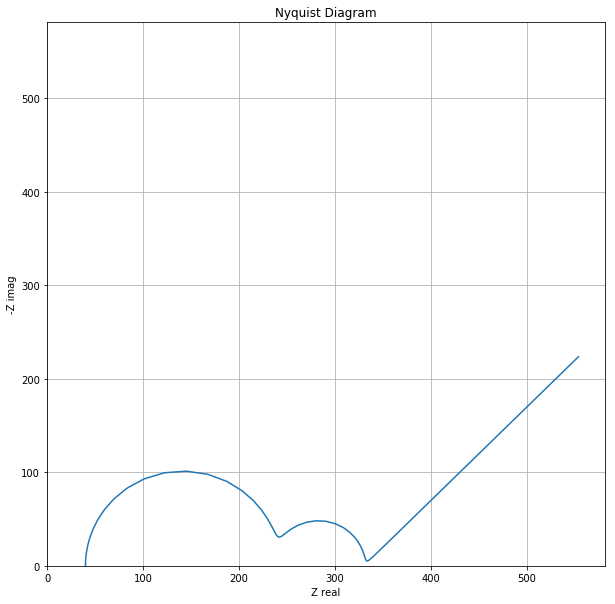

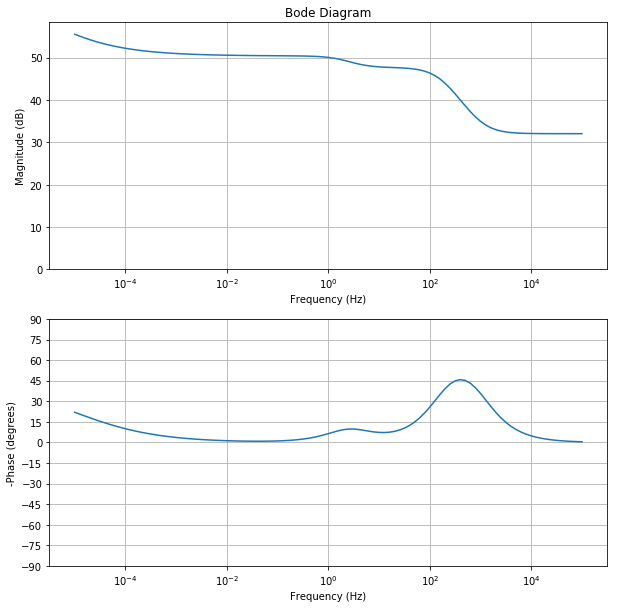

In [7]:
someEquivalentCircuit.plotAll()

Returning the equivalent circuit values as a pandas dataframe:

In [8]:
myShinyNewDataframe = someEquivalentCircuit.to_dataframe()
display(myShinyNewDataframe)

,Frequency (Hz),Z (Ohms),Zreal,Zimag,Radius (Ohms),Magnitude (dB),Phase (degrees)
0,100000.000000,(40.00279166643429-0.3375684753864916j),40.002792,-0.337568,40.004216,32.042115,-0.483486
1,79432.823472,(40.00338947231721-0.4246667168318618j),40.003389,-0.424667,40.005643,32.042425,-0.608216
2,63095.734448,(40.004210637163794-0.5342788738489503j),40.004211,-0.534279,40.007778,32.042889,-0.765172
3,50118.723363,(40.00537038895218-0.6722291381058704j),40.005370,-0.672229,40.011018,32.043592,-0.962677
4,39810.717055,(40.00704946648614-0.8458485042528762j),40.007049,-0.845849,40.015990,32.044671,-1.211195
5,31622.776602,(40.00953219932713-1.0643641827870147j),40.009532,-1.064364,40.023687,32.046342,-1.523867
6,25118.864315,(40.01326682112679-1.3393891679585193j),40.013267,-1.339389,40.035678,32.048944,-1.917182
7,19952.623150,(40.01896100003028-1.685537230252724j),40.018961,-1.685537,40.054441,32.053014,-2.411785
8,15848.931925,(40.02773313765615-2.1211944873617696j),40.027733,-2.121194,40.083898,32.059399,-3.033445
9,12589.254118,(40.04135194332757-2.6694854615013828j),40.041352,-2.669485,40.130238,32.069435,-3.814163
